# Transforming How We Diagnose Heart Disease
Lab prepration: Abel Brown, PhD, Solutions Architect @ NVIDIA


We all have a heart. Although we often take it for granted, it's our heart that gives us the moments in life to imagine, create, and discover. Yet cardiovascular disease threatens to take away these moments. Each day, 1,500 people in the U.S. alone are diagnosed with heart failure—but together, we can help. We can use data science to transform how we diagnose heart disease. By putting data science to work in the cardiology field, we can empower doctors to help more people live longer lives and spend more time with those that they love.

![alt text](img/fig2.jpg "Only One Unit of Time That Matters")

Declining cardiac function is a key indicator of heart disease. Doctors determine cardiac function by measuring end-systolic and end-diastolic volumes (i.e., the size of one chamber of the heart at the beginning and middle of each heartbeat), which are then used to derive the ejection fraction (EF). EF is the percentage of blood ejected from the left ventricle with each heartbeat. Both the volumes and the ejection fraction are predictive of heart disease. While a number of technologies can measure volumes or EF, Magnetic Resonance Imaging (MRI) is considered the gold standard test to accurately assess the heart's squeezing ability.  

However, the current problem with using MRI based cardiac volumes to derive ejection fraction is that the process is performed manually and is therefore quite time consuming.  A skilled cardiologist must analyze MRI scans to determine EF. The process can take up to 20 minutes to complete—time the cardiologist could be spending with his or her patients. Making this measurement process more efficient will enhance doctors' ability to diagnose heart conditions early, and carries broad implications for advancing the science of heart disease treatment.
<img src="img/fig8.png" alt="Manual determination of ejection fraction" style="width: 700px;"/>
<p style="text-align: center;">*C.M.S Nambakhsh et al., Medical Image Analysis 17(2013) 1010-1024*</p>

The [2015 Data Science Bowl](https://www.kaggle.com/c/second-annual-data-science-bowl) challenge was to create an algorithm to automatically measure end-systolic and end-diastolic volumes in cardiac MRIs. In this tutorial you will examine MRI images from more than 1,000 patients. The data set was compiled by the National Institutes of Health and Children's National Medical Center.  This data set is an order of magnitude larger than any cardiac MRI data set released previously providing the opportunity for the data science community to transform heart disease diagnosis.

## Acknowledgments
The Data Science Bowl was a joint effort by Booze Allen Hamilton & Kaggle.  The National Heart, Lung, and Blood Institute (NHLBI) provided the MRI images for this competition. Thanks to NHLBI Intramural Investigators Dr. Michael Hansen and Dr. Andrew Arai.  Additional support for the Data Science Bowl was provided by NVIDIA.

## About NDSB
<img src="img/fig0.png" alt="Are you ready to change the world?" style="width: 250px;"/>

Interested in solving the world's toughest analytic challenges? See if you have what it takes to observe the right patterns and ask the right questions. Whether a seasoned veteran or a newcomer, the Data Science Bowl provides an opportunity to advance the art of data science, benefit society, and inspire change across the globe.  Join the data science community and compete for top honors in the National Data Science Bowl (NDSB), created and sponsored by Booz Allen and Kaggle.

For DSB, data science is more than a skill or profession. It is a calling and a way of life. It rewards grit and talent where failure, curiosity, and small successes all together coalesce into larger scientific advances. Data science grants the power of discovery to the individual.

## The Data Set
In this [dataset](https://www.kaggle.com/c/second-annual-data-science-bowl/data), you are given hundreds of cardiac MRI images in [DICOM](https://en.wikipedia.org/wiki/DICOM) format. These are 2D cine images that contain approximately 30 images across the cardiac cycle. Each slice is acquired on a separate breath hold. This is important since the registration from slice to slice is expected to be imperfect.

The ultimate goal here is to create an automated method capable of determining the left ventricle volume at two points in time: after systole, when the heart is contracted and the ventricles are at their minimum volume, and after diastole, when the heart is at its largest volume.

<img src="img/fig3.gif" alt="MRI imaging of heartbeat" style="width: 500px;"/>

The volumes at systole, $V_S$, and diastole, $V_D$, form the basis of an important clinical measurement known as the [ejection fraction](https://en.wikipedia.org/wiki/Ejection_fraction):

$$100\cdot\frac{V_D-V_S}{V_D}$$

This quantity represents the fraction of outbound blood pumped from the heart with each heartbeat. An ejection fraction that is too low can signify a wide range of cardiac problems.  Variations in anatomy, function, image quality, and acquisition make automated quantification of left ventricle size a challenging problem. You will encounter this variation in the competition dataset, which aims to provide a diverse representation of cases. It contains patients from young to old, images from numerous hospitals, and hearts from normal to abnormal cardiac function. A computational method which is robust to these variations could both validate and automate the cardiologists' manual measurement of ejection fraction.

Each case has an associated directory of DICOM files. The exact number of images will differ from case to case, either varying in the number of slices, the views which are captured, or the number of frames in the time sequences.

The main view for assessing ventricle size is the short axis stack (PSAX), which contains images taken in a plane perpendicular to the long axis (PLAX) of the left ventricle: 

<img src="img/fig6.png" alt="PSAX diagram" style="width: 250px;"/>
<p style="text-align: center;">*image credit: fpnotebook.com*</p>

These have the prefix "sax_" in the dataset. Most cases also have alternative views.

## Evaluation
Performance is evaluated using the Continuous Ranked Probability Score (CRPS). For each MRI, a cumulative probability distribution is predicted for both the systolic and diastolic volumes (two separate distributions per case). The CRPS is computed as follows:

$$CRPS = \frac{1}{600\cdot N}\sum_{m=1}^{N}\sum_{n=0}^{599} (P(y\le n)-H(n-V_{m}))^2$$

where $P$ is the predicted distribution, $N$ is the number of rows in the test set (equal to twice the number of cases), $V$ is the actual volume (in mL) and $H(x)$ is the Heaviside step function ($H(x\lt0)=0$ and $H(x\ge 0)=1$).  While it is not simple to visualize the CRPS, the shaded area on the figure below may be a helpful guide for understanding the error term between the predicted distribution and actual volume:
<img src="img/fig4.png" alt="CRPS error between predicted and actual volume" style="width: 500px;"/>
Note that the entry will not score if any of the predicted values has $P(y \le k) > P(y \le k+1)$ for any $k$.  That is the CDF is non-decreasing.

# End-to-End Deep Learning for NDSB-II

In this example, we will show how to use GPU accelerated MXNet library to build an end-to-end deep learning system to help diagnose heart disease.  Keep in mind, this is a very simple model without any network structure optimizations or hyper parameter tuning.  However, it is possible to build fantastic networks based on the example solution.  While this tutorial is written in R, mxnet comes with support for other popular languages such as Python and Julia. 

## General Overview of model
### Input Data
The data set itself contains 500 training studies with on average 10 unique SAX observation at various points along the the PLAX of the left ventricle.  That’s roughly 5000 observations in total.  Each of these SAX observation usually contain 30 DICOM images (“frames”) in a time sequence which captures an entire heartbeat (expansion and contraction).   The idea here is to pack each of the 30 image frames of an observation into a 64x64x30 tensor.  While this might sound complicated, just think of stacking playing cards to form a deck.  Each card has the same rectangular dimensions (say, 120x90) and then cards are stacked one on top of the other to form a deck.  It’s the same thing here.  We’re going to take each of the 30 square image frames of 64x64 pixels and stack them one-by-one to form an input “deck” to the deep neural network.  The only difference with the card deck analogy is that the image frames are organized in time so that the video clip of the heartbeat is not all garbled.  This tutorial is based on this simple idea: we first find accumulate all suitable observations having 30 frames, then feed to the deep neural network to learn the target directly.

Notice that the label data set contains only 500 labels. That is, each of the roughly 10 SAX observation for a particular study get the same diastole and stytole volume.  Again, each SAX observation of a study is just a different view of the same heart (i.e. a single heartbeat as measured from different cross sections perpendicular to the long axis of the heart).  Therefore, in the data preprocessing step, each label must be duplicated for each unique observation.

Additionally, notice that (in this tutorial at least) the same 64x64x30 deck of images is used to predict both stytole and diastole volumes.  Therefore, we’re going to build a network that ingests each observation tensor to predict stytole volume.  Then a separate network that ingests that same image deck to predict diastole volume.

Another idea used in this tutorial is taking a frame-by-frame difference to measure change per frame (in time).  By using MXNet symbolic interface, we can dynamically difference the input inside of the network. It helps a little in the final result.

### Network Objective
For the network, we use the 20 year old LeNet style convolution network with batch normalization and dropout. This is a basic network with a generic configuration.  In this challance, we are asked to predict a CDF value of 600 data-point. Therefore the problem is formulated as a regression problem. We ask the neural-net that given a stack of images 64x64x30 to output 600x1 vector - one predicted value for each of the 600 points in the CDF.  Note here that the label is just a single floating point value like 83.3 (mL).  This label is transformed into a step function having 600 discrete values where all the y-values of the CDF with x less than 83 are 0 and all y-values with x greater than 83 are 1.


### Preprocessing
We first run a preprocessing step, to pack the data into a csv file (```train-64x64-data.csv```).  Each line of this csv file corresponds to a 64 x 64 x 30 tensor, which gives 30 frames of images. We can also use other inputs besides csv. The CSV is used here since this format is common for all languages and is easy to parse.

The input dataset is quite big (5293 observations of size 64x64x30). While this data set can likely fit into memory of a big machine, we want to be safe, so we will use the ```CSVIter``` from ```mxnet``` to load data from disk on-the-fly during training, without loading all the data into memory at once.

The labels for the training data are stored in ```train-systole.csv``` and ```train-diastole.csv``` where each line is a step function of 0s and 1s as described above. Notice that the line ```i``` in the the training CSV data file is label by the associated line ```i``` in the label CSV files.  Again, when training the stytole network we will use labels from ```train-systole.csv``` and likewise when training the diastole network we will use labels from ```train-diastole.csv```.

### About MXNet
[MXNet](https://github.com/dmlc/mxnet) is a deep learning framework designed for both efficiency and flexibility by DMLC group. MXNet will fully utilize all the resources to solve the problem under limited resource constraint, with a flexible programming interface. You can use it for all purposes of data science and deep learning tasks with R, Julia, python and more. To run on multiple GPU with huge network, or questions about saving network parameters etc, please refer [MXNet docs](https://mxnet.readthedocs.org/en/latest/)


## NDSB Competition Results

Inquiring minds would like to know.  If you're not an inquiring mind, feel free to skip this section and start slinging some R-code. 

There were nearly [200 participants](https://www.kaggle.com/c/second-annual-data-science-bowl/leaderboard) in the NDSB-II with a variety of different approaches to solving this challange. The CRPS scores for the leaderboard top ten ranged from 0.009485 in first place to 0.012611 in tenth place.  To get a better feel for how your results stackup against the competion, we can create an empirical CDF from the leaderboard CRPS scores
<img src="img/fig10.png" alt="CRPS ECDF" style="width: 500px;"/>
Therefore, acheiving a CRPS score of 0.03 is at about the 80th percentile w.r.t. the overall competition results.  

So how much better is a CPRS of 0.009485 than 0.012611?  To get a loose sense for how CPRS effects ejection fraction calculations, the competition provided this infographic to performers

<img src="img/fig11.png" alt="CRPS ECDF" style="width: 700px;"/>

Although, analysis of the competion results seem more favorable than this graphic might imply and noted that top performer models agreed well with previous studies of human performance.  For a medical perspective on the competion results check out this [kaggle blog](https://www.kaggle.com/c/second-annual-data-science-bowl/forums/t/19839/a-medical-perspective-on-the-quality-of-the-left-ventricular-volume-and) by Dr. Andrew Arai of the NIH.  Additional analysis of the clinical applicability provided by Jonathan Mulholland of Booze Allen Hamilton [here](http://www.datasciencebowl.com/leading-and-winning-team-submissions-analysis/). These analysis conclude, based on the top 4 models submitted to the competion, that "*The models keep the diagnosis categories pretty tightly grouped together. While the models are not right 100% the time, there is a very low probability of a severely abnormal EF being incorrectly categorized in the mild to hyperdynamic range. The normal to mild diagnoses are very likely to stay within their domain ... This is a pretty good sign pointing towards suitability for clinical applications*".

## Code

In [2]:
# import libraries
require(mxnet)
require(data.table)
require(ggplot2)

Loading required package: mxnet
Loading required package: data.table
Loading required package: ggplot2


Here we define a function that will stamp out configured (not trained yet) neural networks.  This network is a classic network that has it's origins from Yann LeCun's paper many years ago and hence has the nastalgic name "LeNet".  

Notice here that we create a variable using ```mx.symbol.Variable``` which *represents* the input data.  Just like regular variables we can manipulate the ```source``` variable.  For example, the first thing we do to the image data input is to normalize the pixel values. Next we utilize ```mx.symbol.SliceChannel``` so that we can actually access each individual frame of the input.  Recall that the input is 64x64x30 so that each indexed frame is of size 64x64. The purpose of using the frames is so that differences between successive frames can be calculated. That is, instead of training the network parameters using the images directly, the network is trained on the differences between each successive frame.  This is pretty cool since we can actually manipulate the data with in the network definition rather than having to preprocess the whole dataset when want to experiment with a new idea.  Once each frame delta has been computed the individual frames are put back into a 64x64x29 tensor input using ```mxnet:::mx.varg.symbol.Concat```.  Since we've taken successive deltas we actually only have 29 total deltas now!  

From here we just chain various layers together, such as ```mx.symbol.Convolution```, to form the network described in LeCun's paper.  There is no magic here.  Feel free it add layers inbetween or remove layers etc.  That's part of the fun of working with DL; various recipies have been described in papers over the years but you're free to construct anything you'd like.  Play with the network structure to get a feel for how training performance changes. 



In [3]:
# Create LeNet style network
get.lenet <- function() {
    
    # create data variable (i.e. symbol)
    source <- mx.symbol.Variable("data")
    
    # normalize values of input data 
    source <- (source-128) / 128
    
    # SliceChannel is a symbol that can be indexed just like an array
    frames <- mx.symbol.SliceChannel(source, num.outputs = 30);
    
    # init list of differences
    diffs <- list()
  
    # compute differences for each "frame"
    for (i in 1:29) {
        diffs <- c(diffs, frames[[i + 1]] - frames[[i]])
    }
  
    # set the property for number of arugments in diffs variable
    diffs$num.args = 29
    
    # concatonate frame variables into single variable
    source <- mxnet:::mx.varg.symbol.Concat(diffs)
    
    # convolution layer with 5x5 kernel dimention
    net <- mx.symbol.Convolution(source, kernel = c(5, 5), num.filter = 40)
    
    # normalization layer: simply subtract mean divide by std
    net <- mx.symbol.BatchNorm(net, fix.gamma = TRUE)
    
    # activation layer using Rectified Linear Unit (relu) activation function
    net <- mx.symbol.Activation(net, act.type = "relu")
    
    # Max pooling layer with a 2x2 kernel and no overlap since stride is 2x2
    net <- mx.symbol.Pooling(net, pool.type = "max", kernel = c(2, 2), stride = c(2, 2))
    
    # continue building the network ...
    net <- mx.symbol.Convolution(net, kernel = c(3, 3), num.filter = 40)
    net <- mx.symbol.BatchNorm(net, fix.gamma = TRUE)
    net <- mx.symbol.Activation(net, act.type = "relu")
    net <- mx.symbol.Pooling(net, pool.type = "max", kernel = c(2, 2), stride = c(2, 2))
    
    # flatten the features to single variable
    flatten <- mx.symbol.Flatten(net)
    
    # add a drop out layer where 50% of data gets dropped out at training thime
    flatten <- mx.symbol.Dropout(flatten)
    
    # add the final fully connected layer for output of dimension 600
    fc1 <- mx.symbol.FullyConnected(data = flatten, num.hidden = 600)
    
    # Name the final layer as softmax so it auto matches the naming of data iterator
    # Otherwise we can also change the provide_data in the data iter
    return(mx.symbol.LogisticRegressionOutput(data = fc1, name = 'softmax'))
}

If you want to know more about a particular layer, pull up the help listing for that layer. For example,?mx.symbol.Activation provides the help information for the activation layer where additional functions are listed for use such as 'sigmoid', 'tanh' and so on.

In [4]:
?mx.symbol.Activation

Now the training batch size is specified.  The size can be smaller or larger arbitrarily but since we're using GPUs for the training have to be careful not to use a really large batch size since the GPU has limited memory.  The batch size is also a factor of how large the input images are.  Since each input is a 64x64x30 tensor, 16 is a good size. It is not the end of the world if batch size is too large.  If the batch size is too large, the training command will just fail and complain about something like "device out of memory" which is likely your queue to reduce the batch size.

In [5]:
batch_size <- 16

Next we load the training data using an iterator so that we use host memory efficiently.  This is nice since it does not consume huge amounts of data but the trade off is that it does increase the training time since we have to keep loading data over and over. 

In [6]:
# CSVIter is uesed here, since the data can't fit into memory
data_train <- mx.io.CSVIter(
   data.csv  = "./train-64x64-data.csv", data.shape  = c(64, 64, 30),
  label.csv  = "./train-systole.csv"   , label.shape = 600,
  batch.size = batch_size
)

Lets now initialize a LeNet style network using our network function.  This network has structure but none of the parameters are determined yet.  Think of it as raw materials that will be shaped into meaningful values/parameters during the training phase.  Notice that when this function is called all of the parameters are initialized to random values which does actually consume memory on the system.  If the network has 10 million parameters in it then we have to initialize 10 million values in memory.  Also, all the network parameters must actually fit into the GPU memory also (with the input data too!) so if the network structure is too large then it is possible to run out of memory on the GPU.  So start conservatively and grow the network as you work through the performance requirements. 

In [7]:
network <- get.lenet()

Before we can train the network parameters we must specify a *loss function* also called a *cost function*.  This function tells the training algoritm how closely the current set of parameters reproduce the target output.  In general, for a given cost function the training algorithm will try to choose parameters for which the cost function is minimized.  That is, a lower cost is better than higher cost. 

In [8]:
# Custom evaluation metric using CRPS.
costfun <- function(label, pred) {
  pred  <- as.array(pred )
  label <- as.array(label)
  return(sum((label - pred) ^ 2) / length(label))
}

# create custom mxnet metric for training
mx.metric.CRPS <- mx.metric.custom("CRPS", costfun)

OK, so here is where the network is trained on the data.  Notice that the number of training rounds is specified at 65 which will take a long time.  Try using a much smaller number such as 5 or 10 just to get a feel for how the training goes.  Due to how iPython works, the incremental training performance is only printed at the end.  Outside of iPython, these incremental updates are printed out after each round of training.  Once you feel comfortable, feel free to play around with the learning rate, momentum etc and see how the training performance changes.

Notice that one of the arguments provided is ```ctx = mx.gpu(0)``` which effectively tells mxNet to use GPU with device id equal to 0.  If you want to perform the training with the CPU instead then set the context to ```ctx=mx.cpu()```.  Furthermore, an array of GPU devices can be passed into the context for multi-gpu training if there are more than one GPU devices present on the machine.  Keep in mind here that using multiple GPU devices for training incurs some overhead so requires a very large dataset.  It's not unusual that training time actually increases when using multiple GPU due to the additional data transfer required. So definatly start small and grow the training strategy and always profile execution times etc to keep an eye on learning performance. 

If you want to save some time, simply load the pretrained model using the cell below and skip evaluating the training cell.

In [9]:
# load the pretrained result
stytole_model <- mx.model.load("diastole_model",65)

In [10]:
# Training the stytole model (this takes a long time, can load the model instead if you want).

# set the random seed so the results are reproduceble
mx.set.seed(0)

# start the clock
start_time <- proc.time()

# train the model parameters with the data
stytole_model <- mx.model.FeedForward.create(
  X             = data_train,
  ctx           = mx.gpu(0) ,
  symbol        = network   ,
  num.round     = 5         ,
  learning.rate = 0.01      ,
  wd            = 0.0001    ,
  momentum      = 0.9       ,
  eval.metric   = mx.metric.CRPS
)

# get the time delta
proc.time() - start_time

Start training with 1 devices
[1] Train-CRPS=0.0481666858644478
[2] Train-CRPS=0.0343576781879429
[3] Train-CRPS=0.0332061321633546
[4] Train-CRPS=0.0321405777226778
[5] Train-CRPS=0.0310251485358186


   user  system elapsed 
139.364  40.648  69.825 

If you've trained a network and want to save the results then export the trained model so it can be reloaded without having to perform training phase next time

In [12]:
# Save the trained neural network model to disk.
# This creates two files: 
#    1. stytole_model-0065.params
#    2. stytol_model-symbol.json
#
# WARNING: the 65 here must match num.rounds parameter provided to mx.model.FeedForward.create
#          So if the model was saved at 65, then it must be loaded with 65.
#
mx.model.save(stytole_model,"diastole_model",65)

Just to get a better feel for the data, lets extract all the data from the CSV iterator.  Doing this reads in the entire dataset in to host memory.  This can be prohibative with a large dataset.  

In [13]:
# this reads in all the data at once (not a great idea, but we can do it)
labels <- mx.io.extract(data_train,"label")
data   <- mx.io.extract(data_train,"data" )

Once the data has been loaded we can check the dimensions.  As advertized we have ~ 5000 training samples each of size 64x64x30.  Oddly enough, mxnet reports that we have either a missing label or and extra data?

In [14]:
# notice we have a missing label or an extra data
dim(labels)
dim(data)

[1]  600 5293

[1]   64   64   30 5293

Using the trained model we can pass input samples into the model to predict their styolic volume.  To select various samples we index into the data variable ```data[,,,1:20]``` to extract some samples. Notice here we're selecting input data along the 4th dimension.  That is we're selecting ```N``` input samples with dimension 64x64x30 and by leaving the first three index empty we are effectively saying "give me everything" along that dimension.

In [15]:
# create index for selecting samples
sample_index = c(1:20);

# apply the model to just a few data to generate some predictions
model_predictions <- predict(stytole_model, data[,,,sample_index])

Now lets have a look at what was predicted by the model for these input.  Try selecting a different index for the plot to view other predictions and their label.  Don't hesitate to predict more input in the cell above to investigate even further.

[1] 0.02454931

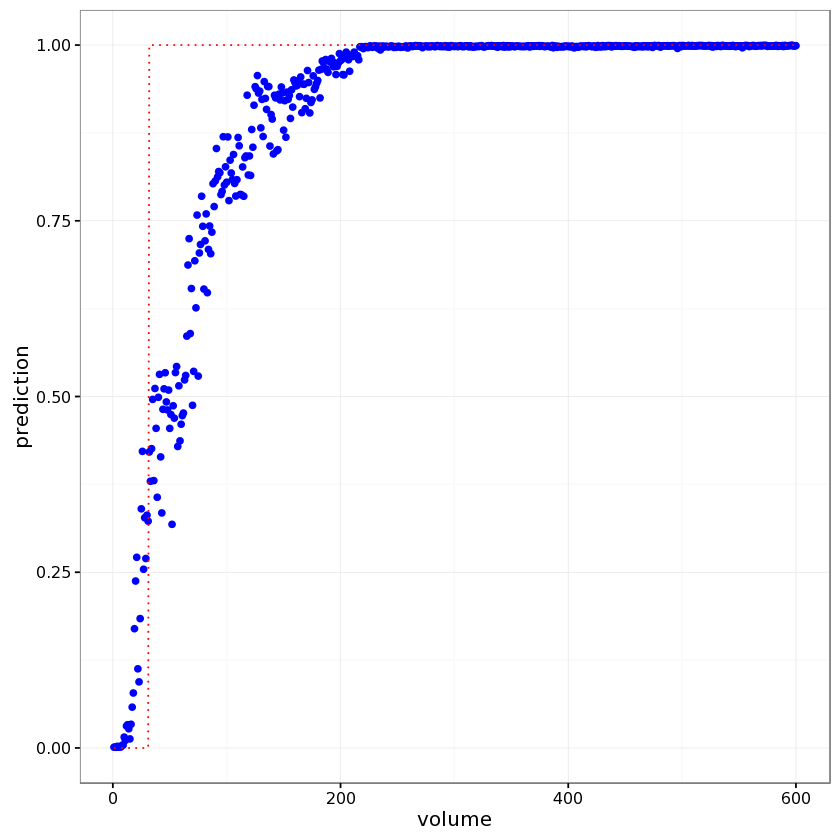

In [16]:
# have a look at what the label and associated prediction looks like
ix = 14;
x  <- seq(1, 600, 1)
y1 <- model_predictions[,ix]
y2 <- labels[,ix]
df <- data.frame(volume=x,prediction=y1,label=y2)

# basic graphical object
ggplot(df, aes(volume)) +
  
  # the predicted CDF using the trained model
  geom_point(aes(y=prediction), color="blue") +  

  # the label for this set of images (i.e. stytole volume)
  geom_line(aes(y=label), color="red", linetype="dotted") + 

  # make the plot theme simple 
  theme_bw()

# evaluate the cost function for this prediction
costfun(labels[,ix],model_predictions[,ix])

Notice how the prediction(blue curve) is a logistic like curve (CDF) while the label is a step function.  Certainly we can use our cost function to get a sense for how "close" the set of predictions are to their labels.  However, notice with this formulation of the problem it's not very easy to simple look at the prediction and call out what the actual volume predicted is.  

In [17]:
costfun(labels[,sample_index],model_predictions[,sample_index])

[1] 0.02612443

## OK Now it is your Turn!

Lets use what we've learned from creating the ```stytole_network``` and create a network to predict diastole volume.

Step 1. create a training data set using the diastole labels 

Step 2. create network 

Step 3. Train the network


In [ ]:
# step 1


In [ ]:
# step 2


In [ ]:
# step 3


## Discovery Requires Experimentation ...

There are many ways to explore and even improve this model.

1. Maybe try removing batch normalization layers ([ref](https://arxiv.org/abs/1502.03167))[hint: modify get.lenet()]
2. Try increasing or decreasing the number of features in the convolution layer [hint: modify ```num.filter``` in get.lenet()]
3. How does batch size effect training?
4. Have a go at modifying the learning rate and momentum of the training phase [hint: learning.rate, wd, and momentum]
5. Notice that the CPRS function uses the residual squared.  What else might we try (hint: try abs in costfun)
6. Try using different activation function (i.e. other than relu).  How does this effect performance?
7. Maybe try using different pooling functions (i.e. other than max)[hint: use help to see other functions]
8. Maybe try removing dropout layer or modifying the percentage dropout (i.e. default is 50%)
9. Maybe try double differencing the data or not differencing the data at all
10. What are other ways we could formulate the network output (i.e. other than discrete CDF)?